Lab 4: Extending Logistic Regression

Cameron Matson

Zihao Mao

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [110]:
# first lests load the datasets in

data_path = '../../data/nba-players-stats-since-1950'
players = pd.read_csv(os.path.join(data_path, 'players.csv'))
players.head()

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


We probably don't need the "collage [sic]" or the their birth locationg.  Probably don't really need their birth year either, but it might be interesting to look at generational splits.  Also that unnamed column looks just like the index, so we can drop that too.

In [111]:
players.drop(['Unnamed: 0', 'collage', 'birth_city', 'birth_state', 'born'], axis=1, inplace=True)
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 3 columns):
Player    3921 non-null object
height    3921 non-null float64
weight    3921 non-null float64
dtypes: float64(2), object(1)
memory usage: 92.0+ KB


Good.  They're all non null, and seem to be the correct datatype.

Now let's load the players stats.

In [112]:
stats = pd.read_csv(os.path.join(data_path, 'seasons_stats.csv'))
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 53 columns):
Unnamed: 0    24691 non-null int64
Year          24624 non-null float64
Player        24624 non-null object
Pos           24624 non-null object
Age           24616 non-null float64
Tm            24624 non-null object
G             24624 non-null float64
GS            18233 non-null float64
MP            24138 non-null float64
PER           24101 non-null float64
TS%           24538 non-null float64
3PAr          18839 non-null float64
FTr           24525 non-null float64
ORB%          20792 non-null float64
DRB%          20792 non-null float64
TRB%          21571 non-null float64
AST%          22555 non-null float64
STL%          20792 non-null float64
BLK%          20792 non-null float64
TOV%          19582 non-null float64
USG%          19640 non-null float64
blanl         0 non-null float64
OWS           24585 non-null float64
DWS           24585 non-null float64
WS          

There are a lot of fields here, and they're pretty inconsistently filled.  Some of this arises from the fact that its such a long timeline.  For example, in 1950, there was no such thing as a 3-pointer, so it wouldn't make sense for those players to have 3pt% stats. 

Inspecting the dataset a little further, we notice that there is no stat for points per game (PPG).  The total number of points scored is listed, but that is hard to compare across seasons where they played different games.  To make the dataset more valid, i.e. to make the points column a valid comparisson measure, we'll only consider seasons in which they played the current full 82 game schedule.  Which doesn't reduce the power of the dataset by that much, they moved to a 82 game season in 1967, and only the lockout shortened 1998-99 season didn't have a full scehdule.

Actually we might want to limit it to just seasons after 1980 when they introduced the 3 pointer.  That should just make the prediction task easier, although we lose even more of the dataset.  But if we consider the business case as being how to decide players posisitions *TODAY* it makes sense.

In [113]:
stats = stats[stats.Year >= 1980]
stats = stats[stats.Year != 1998]
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18380 entries, 5727 to 24690
Data columns (total 53 columns):
Unnamed: 0    18380 non-null int64
Year          18380 non-null float64
Player        18380 non-null object
Pos           18380 non-null object
Age           18380 non-null float64
Tm            18380 non-null object
G             18380 non-null float64
GS            17686 non-null float64
MP            18380 non-null float64
PER           18375 non-null float64
TS%           18307 non-null float64
3PAr          18295 non-null float64
FTr           18295 non-null float64
ORB%          18375 non-null float64
DRB%          18375 non-null float64
TRB%          18375 non-null float64
AST%          18375 non-null float64
STL%          18375 non-null float64
BLK%          18375 non-null float64
TOV%          18321 non-null float64
USG%          18375 non-null float64
blanl         0 non-null float64
OWS           18380 non-null float64
DWS           18380 non-null float64
WS       

Now lets just focus on a few categories
- Player
- Year
- Age
- games played (G)
- minutes played (MP)
- field goals, feild goal attempts, and percentage (FG, FGA, FG%)
- free throws (FT, FTA, FT%), two-pointers (2P, 2PA, 2P%), and three-pointers (3P, 3PA, 3P%)
- offensive, defensive, and total rebounds (ORB, DRB, TRB)
- assists (AST)
- steals (STL)
- blocks (BLK)
- turnovers (TOV)
- personal fouls (PF)
- points (PTS)

And of course our label: position.  We could probably use any of the features as a label actually, and see if one could predict performance in one aspect of the game based on info in the another.  But for now we'll stick with predicting position.


In [114]:
stats_to_keep = {'Player', 'Year','Pos', 'Age', 'G', 'MP', 'FG', 'FGA', 'FG%', 'FT', 'FTA', 'FT%',
                '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
                'TOV', 'PF', 'PTS'}

stats_to_drop = set(stats.columns)-stats_to_keep
stats.drop(stats_to_drop, axis=1, inplace=True)
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18380 entries, 5727 to 24690
Data columns (total 27 columns):
Year      18380 non-null float64
Player    18380 non-null object
Pos       18380 non-null object
Age       18380 non-null float64
G         18380 non-null float64
MP        18380 non-null float64
FG        18380 non-null float64
FGA       18380 non-null float64
FG%       18295 non-null float64
3P        18380 non-null float64
3PA       18380 non-null float64
3P%       14969 non-null float64
2P        18380 non-null float64
2PA       18380 non-null float64
2P%       18266 non-null float64
FT        18380 non-null float64
FTA       18380 non-null float64
FT%       17657 non-null float64
ORB       18380 non-null float64
DRB       18380 non-null float64
TRB       18380 non-null float64
AST       18380 non-null float64
STL       18380 non-null float64
BLK       18380 non-null float64
TOV       18380 non-null float64
PF        18380 non-null float64
PTS       18380 non-null float64

To take care of some of the null values, when players had 0 attempts in a shooting category (FG, 3P, 2P, FT) they left the percentage field blank (can't divide by 0), but for our purposes its probably okay if we just say it was 0%.

In [115]:
stats['3P%'] = stats['3P%'].fillna(0)
stats['2P%'] = stats['2P%'].fillna(0)
stats['FT%'] = stats['FT%'].fillna(0)
stats['FG%'] = stats['FG%'].fillna(0)


Okay.  Finally, let's add the player description data to the stats dataframe.

In [116]:
stats['height'] = np.nan
stats['weight'] = np.nan

In [117]:
iplayer = players.set_index(keys='Player')
istats = stats.reset_index(drop=True)
for i, row in istats.iterrows():
    name = row[1]
    h = iplayer.loc[name].loc['height']
    w = iplayer.loc[name].loc['weight']
    istats.iloc[i, 27] = h
    istats.iloc[i, 28] = w


In [118]:
stats = istats

In [119]:
# and now we don't need the names anymore
stats.drop(['Player', 'Year'], axis=1, inplace=True)

# Logistic Regression Model

In [120]:
import numpy as np
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
        
blr = BinaryLogisticRegressionBase(0.1)
print(blr)

Base Binary Logistic Regression Object, Not Trainable


In [121]:
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_bias=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

            
blr = BinaryLogisticRegression(0.1)
print(blr)

Untrained Binary Logistic Regression Object


In [234]:
# now lets do some vectorized coding
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        yhat = self.predict_proba(X, add_bias=False).ravel()[:, np.newaxis]
        ydiff = y-yhat # get y difference

        
        gradient = np.mean(X * ydiff, axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)



In [217]:
# first we need to separate out the label from the data
y = stats.Pos
set(y)

{'C',
 'C-PF',
 'C-SF',
 'PF',
 'PF-C',
 'PF-SF',
 'PG',
 'PG-SF',
 'PG-SG',
 'SF',
 'SF-PF',
 'SF-SG',
 'SG',
 'SG-PF',
 'SG-PG',
 'SG-SF'}

In [218]:
# lets reclassify this numerically and only count their 'primary ' position, so that each player will be given a position 1-5
# {(1, pg), (2, sg), (3, sf), (4, pf), (5, c)}

In [219]:
import numpy as np
def convert_pos(y):
    newy = np.zeros((len(y), 1))
    for i, player in enumerate(y):
        if (player[0] == 'C'):
            newy[i] = 5
        elif (player[0:2] == 'PF'):
            newy[i] = 4
        elif (player[0:2] == 'SF'):
            newy[i] = 3
        elif (player[0:2] == 'SG'):
            newy[i] = 2
        elif (player[0:2] == 'PG'):
            newy[i] = 1
    return newy

In [220]:
y = convert_pos(y)
y

array([[ 5.],
       [ 4.],
       [ 5.],
       ..., 
       [ 5.],
       [ 3.],
       [ 5.]])

In [221]:
y.shape

(18380, 1)

In [222]:
X = stats.drop('Pos', axis=1)

In [223]:
from sklearn import preprocessing

X = preprocessing.scale(X, axis=1)

In [224]:
print(X.shape)
print(y.shape)

(18380, 26)
(18380, 1)


## Binary Case

In [225]:
yb = (y>4).astype(np.int)
print(yb.shape)

(18380, 1)


In [226]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size=0.2)


In [235]:
%%time
from sklearn.metrics import accuracy_score

# Now we can train the classifier
params = dict(eta=0.2,
              iterations=1000)
blr = VectorBinaryLogisticRegression(**params)
blr.fit(X_train,y_train)
print(blr.w_)
yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

[[-0.33417179]
 [-0.29242637]
 [ 0.05288225]
 [-0.62882745]
 [-0.05254612]
 [-0.98733578]
 [-0.18516478]
 [-0.66762493]
 [-1.72791743]
 [-0.20139884]
 [ 0.42976244]
 [ 0.55526528]
 [-0.1875345 ]
 [-0.09727805]
 [ 0.12954605]
 [-0.19288822]
 [ 0.45455409]
 [ 1.33830389]
 [ 1.97817434]
 [-1.62281839]
 [-0.866978  ]
 [ 1.44856858]
 [-0.15530826]
 [ 1.29662916]
 [-0.3140461 ]
 [-0.62939831]
 [ 1.12580547]]
Accuracy of:  0.852829162133
Wall time: 3.18 s


## Multiclass

In [236]:
class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
lr = LogisticRegression(0.1,1500)
print(lr)

Untrained MultiClass Logistic Regression Object


In [239]:
## %%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = LogisticRegression(0.1,1000)
lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ -3.16384944e-01   3.11871606e-01   1.92616320e-01   1.24426019e-01
   -1.64743318e-01  -7.14583433e-03   1.36211566e-01   1.91117638e-01
    4.11670383e-01   1.41637279e-01  -2.21696359e-01  -2.84651620e-01
    1.37133244e-01   4.64241998e-02  -1.29458514e-01   1.44426747e-01
   -7.82113053e-01  -1.18525826e+00  -2.10153591e+00   3.52385843e+00
    4.96093439e-01  -3.31854793e-01   7.26704678e-01  -3.38744015e-01
   -4.94438588e-01   1.02169630e-01  -6.44720922e-01]
 [ -3.81898417e-01   2.12443557e-01   3.90683983e-01  -8.46257378e-02
    1.64096577e-01   6.00138124e-01   2.80943393e-01   4.61967232e-01
    8.52015501e-01   2.89078330e-01  -1.49177948e-02   3.10754833e-02
    2.81545482e-01   1.46050949e-01  -3.06215218e-02   2.91697584e-01
   -3.82610751e-01  -1.09152529e+00  -1.75708890e+00  -4.72292476e-01
    4.18096642e-01  -8.52402100e-02  -2.69741378e-04  -2.50650513e-01
    8.73527531e-02  -1.81013200e-02  -3.19241337e

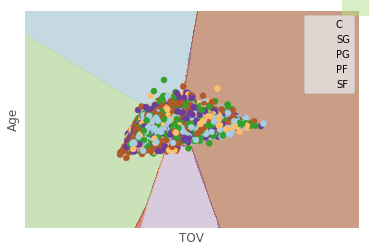

In [376]:
# linear boundaries visualization from sklearn documentation
from matplotlib import pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

def plot_decision_boundaries(lr,Xin,y,title=''):
    Xb = copy.deepcopy(Xin)
    
    # pick two random columns
    (one, two) = np.random.randint(0,X.shape[1], 2)
    
    
    lr.fit(Xb[:,(one, two)],y) # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel(stats.columns[one])
    plt.ylabel(stats.columns[two])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()
    
lr = LogisticRegression(0.1,1500) # this is still OUR LR implementation
plot_decision_boundaries(lr,X_train,y_train)

In [350]:
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, regularization='L2'):
        self.eta = eta
        self.iterations = iterations
        self.C = C
        self.regularization = regularization
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        
        yhat = self.predict_proba(X, add_bias=False).ravel()[:, np.newaxis]
        ydiff = y-yhat # get y difference

        
        gradient = np.mean(X * ydiff, axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        # gradient will be different depending on which regularization technique we use
    
        gradient[1:] 
        L1 = np.sign(w_[1:]) * self.C
        L2 = -2 * self.w_[1:] * self.C
        if (self.regularization=='L1'):
            gradient[1:] += L1
        if (self.regularization == 'L2'):
            gradient[1:] += L2
        if (self.regularization == 'L1/L2'):
            gradient[1:] += (L1 + L2)
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iterations):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

blr.fit(X,y)
print(blr)

yhat = blr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[ 100.8240577 ]
 [ -38.02762117]
 [ -36.38648063]
 [ 338.5865417 ]
 [  -3.71530316]
 [  62.74259541]
 [ -60.67104796]
 [ -56.55537161]
 [ -47.63471685]
 [ -60.93564562]
 [  -8.19032175]
 [  49.34692206]
 [ -60.66036577]
 [ -32.31810938]
 [ -20.14227123]
 [ -60.52391986]
 [ -32.6296847 ]
 [  -1.44844092]
 [  26.95226457]
 [ -38.21490233]
 [ -49.75933184]
 [ -48.83349714]
 [ -37.61932445]
 [ -14.06564886]
 [  86.78708327]
 [ 115.94097107]
 [  27.97562714]]
Accuracy of:  0.199891186072


In [359]:
import warnings
class LRClassifier:
    def __init__(self, eta, iterations=20, C=0.001, optimization='full', regularization='L2'):
        self.eta = eta
        self.iterations = iterations
        self.C = C
        self.opt = optimization
        self.regularization = regularization
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            
            
            # train the binary classifier for this class
            if (self.opt == 'stochastic'):
                blr = StochasticLogisticRegression(self.eta, self.iterations, self.C, self.regularization)
            elif (self.opt == 'hessian'):
                blr = HessianBinaryLogisticRegression(self.eta, self.iterations, self.C, self.regularization)
            elif (self.opt == 'bfgs'):
                blr = BFGSBinaryLogisticRegression(_, 3, self.C, self.regularization)
            else:
                blr = BinaryLogisticRegression(self.eta, self.iterations, self.C, self.regularization)
            
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

    def score(self,*args, **kwargs):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)
    
    # lifted straight out of sklearn source code with some modifications
    @classmethod
    def _get_param_names(cls):
        # this is just specific to this classifier
        return sorted(['eta', 'iterations', 'C', 'optimization', 'regularization'])

    def get_params(self, deep=True):
        """Get parameters for this estimator.
        Parameters
        ----------
        deep : boolean, optional
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            # We need deprecation warnings to always be on in order to
            # catch deprecated param values.
            # This is set in utils/__init__.py but it gets overwritten
            # when running under python3 somehow.
            warnings.simplefilter("always", DeprecationWarning)
            try:
                with warnings.catch_warnings(record=True) as w:
                    value = getattr(self, key, None)
                if len(w) and w[0].category == DeprecationWarning:
                    # if the parameter is deprecated, don't show it
                    continue
            finally:
                warnings.filters.pop(0)

            # XXX: should we rather test if instance of estimator?
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__' + k, val) for k, val in deep_items)
            out[key] = value
        return out
     
    def set_params(self, **params):
        """Set the parameters of this estimator.
        The method works on simple estimators as well as on nested objects
        (such as pipelines). The latter have parameters of the form
        ``<component>__<parameter>`` so that it's possible to update each
        component of a nested object.
        Returns
        -------
        self
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)
        # changed from six.iteritems() bc no need for py2 vs py3 compatabillity
        for key, value in params.items():
            split = key.split('__', 1)
            if len(split) > 1:
                # nested objects case
                name, sub_name = split
                if name not in valid_params:
                    raise ValueError('Invalid parameter %s for estimator %s. '
                                     'Check the list of available parameters '
                                     'with `estimator.get_params().keys()`.' %
                                     (name, self))
                sub_object = valid_params[name]
                sub_object.set_params(**{sub_name: value})
            else:
                # simple objects case
                if key not in valid_params:
                    raise ValueError('Invalid parameter %s for estimator %s. '
                                     'Check the list of available parameters '
                                     'with `estimator.get_params().keys()`.' %
                                     (key, self.__class__.__name__))
                setattr(self, key, value)
        return self

        

In [379]:
#from sklearn.model_selection import GridSearchCV
parameters = {'C':[1, 5, 10]}
lrc = LRClassifier(eta=0.1)
clf = GridSearchCV(lrc, parameters)
clf.fit(X, y)


GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.LRClassifier object at 0x0000019D93601A20>,
       fit_params=None, iid=True, n_jobs=1, param_grid={'C': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [380]:
clf.cv_results_

{'mean_fit_time': array([ 0.2819736 ,  0.26479952,  0.25956043]),
 'mean_score_time': array([ 0.01977348,  0.01562738,  0.01562659]),
 'mean_test_score': array([ 0.16706502,  0.17582407,  0.19385168]),
 'mean_train_score': array([ 0.16706565,  0.17582517,  0.19385201]),
 'param_C': masked_array(data = [1 5 10],
              mask = [False False False],
        fill_value = ?),
 'params': [{'C': 1}, {'C': 5}, {'C': 10}],
 'rank_test_score': array([3, 2, 1]),
 'split0_test_score': array([ 0.0984222 ,  0.09989119,  0.19113166]),
 'split0_train_score': array([ 0.0984222 ,  0.09989119,  0.19113166]),
 'split1_test_score': array([ 0.22404788,  0.23144723,  0.19047878]),
 'split1_train_score': array([ 0.22404788,  0.23144723,  0.19047878]),
 'split2_test_score': array([ 0.17872688,  0.19613711,  0.19994559]),
 'split2_train_score': array([ 0.17872688,  0.19613711,  0.19994559]),
 'std_fit_time': array([ 0.01939531,  0.00316119,  0.00914496]),
 'std_score_time': array([  6.39836968e-03,   5.15

In [381]:
lrc = LRClassifier(eta=0.1, C=10)
lrc.fit(X_train,y_train)
accuracy_score(y_test,lrc.predict(X_test))

0.18416757344940152